**Import Dependencies and Pretrained Model**

In [245]:
import numpy as np
import tensorflow as tf

In [246]:
model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [247]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array #helper functions to upload and process images
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
 
import matplotlib.pyplot as plt
%matplotlib inline

In [248]:

def load_and_process_img(image_path):
  img = load_img(image_path,target_size=(1000,1000))
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img,axis = 0) #An Optional Dimension inorder to reshape from (1000,1000,3) to (1,1000,1000,3)
  return img

In [249]:
def deprocess(x):
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
 
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0) #Removing the Optional Dimensions
 
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

In [250]:
from google.colab import files
files.upload()
from IPython.display import clear_output
clear_output()

In [251]:

content_image_name = 'content.jpg'
style_image_name = 'style.jpg'
content_path = '/content/' + content_image_name
style_path = '/content/' + style_image_name

In [252]:

content = load_and_process_img(content_path)
style = load_and_process_img(style_path)

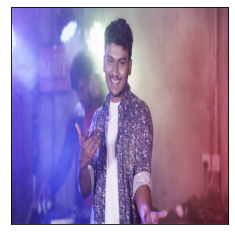

In [253]:
plt.figure()
display_image(content)

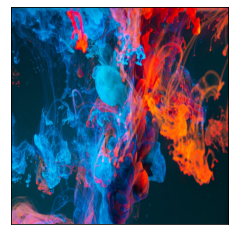

In [254]:

display_image(style)

In [255]:
style_layers = [
                'block1_conv1',
                'block3_conv1',
                'block5_conv1'
] #Each layer inside this list can be given a weightage of how much they contribute in the forward propagation
 
content_layer = 'block5_conv1'

In [256]:
#Defining the input and output for the model
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output) 
style_models = [Model(inputs = model.input,outputs = model.get_layer(layer).output) for layer in style_layers]

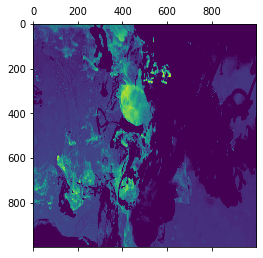

In [257]:

index = 0
a_S = style_models[index](style)
plt.matshow(a_S[0,:,:,12])

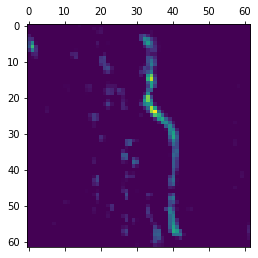

In [258]:

a_C = content_model(content)
plt.matshow(a_C[0,:,:,6])

In [259]:
def content_cost(content,generated): #This function is used to compute cost of content image with respect to the generated image
  a_C = content_model(content)
  a_G = content_model(generated)
  cost =  tf.reduce_mean(tf.square(a_C-a_G))
  return cost

In [260]:
def gram_matrix(A): #gram matrix to be used in computing style cost
  channels = int(A.shape[-1])
  a = tf.reshape(A,[-1,channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a,transpose_a = True)
  return gram/tf.cast(n,tf.float32)

In [261]:
lam = 1/len(style_models)   #compute cost of style image with respect to the generated image
def style_cost(style,generated):
  J_style = 0
  current_cost = []
  for style_model in style_models:
    a_S = style_model(style)
    a_G = style_model(generated)
    G_s = gram_matrix(a_S)
    G_g = gram_matrix(a_G)
    current_cost.append(tf.reduce_mean(tf.square(G_s-G_g)))
  J_style = (4/6)*current_cost[0] + (1/6)*current_cost[1] + (1/6)*current_cost[2]

  #The layers defined in the list style_layers are given weightages (4/6),(1/6) and (1/6) respectively.
  #The weightages vary from image to image and the patterns you want to implement from the style image
 
  return J_style

  #print(style_cost(content,style))

In [262]:
generated_images = []
def training_loop(content_path,style_path,iterations,alpha,beta,lr_rate):
  content = load_and_process_img(content_path)
  style = load_and_process_img(style_path)
  generated = tf.Variable(content)
  min_costs = []
  
 
  opt = tf.optimizers.Adam(learning_rate = lr_rate)
  J_min = 1e12 + 0.1
  for i in range(iterations+1):
    
    with tf.GradientTape() as tape: #Defining tf.GradientTape
      J_content = content_cost(content,generated)
      J_style = style_cost(style,generated)
      J_cost = alpha*J_content + beta*J_style
    
    grads = tape.gradient(J_cost,generated)
    opt.apply_gradients([(grads,generated)])
    if J_cost<J_min:
      J_min = J_cost #It will pick the generated image with the lowest J_cost
      best_pic = generated.numpy()
    if i%2 == 0:
      print('cost at iteration '+str(i)+' = '+ str(J_cost.numpy()))
      generated_images.append(generated.numpy())
  
  return best_pic

In [263]:
itr = 200
alpha = 20
beta = 90
lr = 9
final = training_loop(content_path,style_path,itr,alpha,beta,lr)

cost at iteration 0 = 221788680000.0
cost at iteration 2 = 84052030000.0
cost at iteration 4 = 65257800000.0
cost at iteration 6 = 33949252000.0
cost at iteration 8 = 24173679000.0
cost at iteration 10 = 18529438000.0
cost at iteration 12 = 15269608000.0
cost at iteration 14 = 12276046000.0
cost at iteration 16 = 10012787000.0
cost at iteration 18 = 8544470500.0
cost at iteration 20 = 7368471600.0
cost at iteration 22 = 6371326000.0
cost at iteration 24 = 5534720500.0
cost at iteration 26 = 4869328400.0
cost at iteration 28 = 4314234400.0
cost at iteration 30 = 3860873200.0
cost at iteration 32 = 3470651100.0
cost at iteration 34 = 3132635600.0
cost at iteration 36 = 2843450600.0
cost at iteration 38 = 2597776600.0
cost at iteration 40 = 2385334800.0
cost at iteration 42 = 2201194200.0
cost at iteration 44 = 2042880300.0
cost at iteration 46 = 1905535200.0
cost at iteration 48 = 1784959400.0
cost at iteration 50 = 1678123400.0
cost at iteration 52 = 1584244400.0
cost at iteration 54 = 

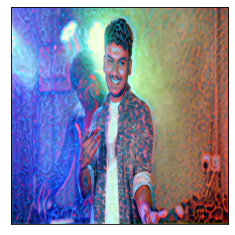

In [264]:
display_image(final) #Display the Final Output

In [265]:
result = np.squeeze(generated_images[-1], axis = 0) #reduce the extra dimension
result = deprocess(result)
result = tf.keras.preprocessing.image.array_to_img(result)
result = result.save('output.jpg')